In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import pickle

# Import the data

In [20]:
dataframe = pd.read_csv('heart.csv')

In [21]:
dataframe.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Using .corr, 
I pulled 'restecg', 'chol', 'thalachh', 'fbs', and 'cp' since their correlation with the output was lower than other features

(Which KNN needs)

In [22]:
dataframe.corr()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trtbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalachh,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exng,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


In [48]:
features = dataframe.loc[:, ['restecg', 'chol', 'thalachh', 'fbs', 'cp']]
true_values = dataframe.iloc[:, [13]]

combined = pd.concat([features, true_values], axis=1, sort=False)
df_array = combined.to_numpy()

combined.head()

,restecg,chol,thalachh,fbs,cp,output
0,0,233,150,1,3,1
1,1,250,187,0,2,1
2,0,204,172,0,1,1
3,1,236,178,0,1,1
4,1,354,163,0,0,1


In [49]:
X = df_array[:, 0:5]
y = df_array[:, 5]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNN classifier
k = 5  # Number of neighbors

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
    ('knn', KNeighborsClassifier(n_neighbors=k))  # k-NN classifier
])



# Train the classifier
knn_pipeline.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = knn_pipeline.predict(X_test_scaled)

# Evaluate the model
accuracy = knn_pipeline.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.819672131147541


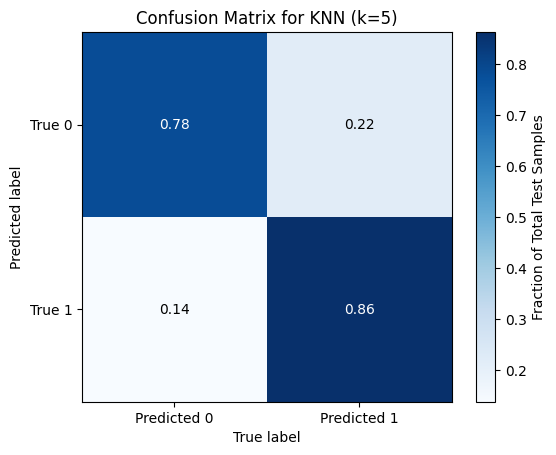

In [50]:
cm = confusion_matrix(y_pred, y_test)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN (k={})'.format(k))
cbar = plt.colorbar()
cbar.set_label('Fraction of Total Test Samples')
plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], ['True 0', 'True 1'])
plt.xlabel('True label')
plt.ylabel('Predicted label')

thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

plt.show()

# ROC-AUC CURVE

note: had to scale the X_test for KNN.

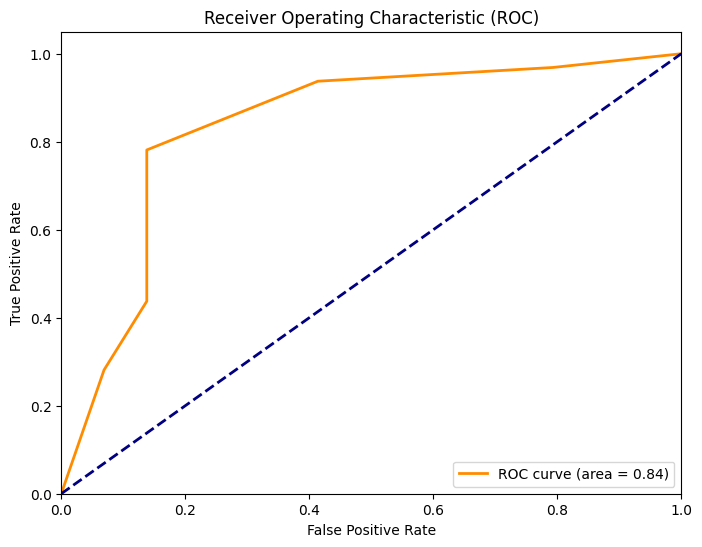

In [51]:
y_scores = knn_pipeline.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# PRECISION-RECALL CURVE

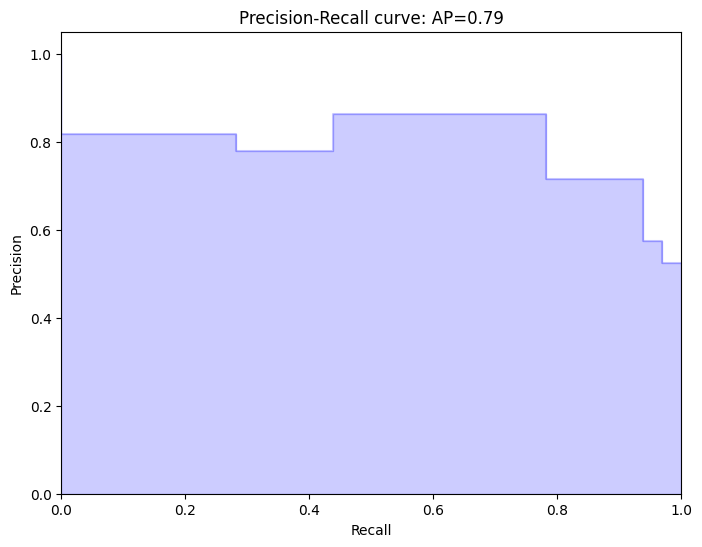

In [52]:
# Precision and Recall

prec, rec, _ = precision_recall_curve(y_test, y_scores)
average_prec = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.step(rec, prec, color='b', alpha=0.2, where='post')
plt.fill_between(rec, prec, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_prec))
plt.show()

In [53]:
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(knn_pipeline, file)